In [1]:
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense,Conv2D, Activation, BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D, Dropout, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import concatenate
import numpy as np
import matplotlib.pyplot as plt

C:\Users\JHLee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def composite_f(x, nb_filter, weight_decay=1E-4):
    
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
        
    x= BatchNormalization(axis=bn_axis, gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x= Conv2D(nb_filter,(3,3),kernel_initializer = 'he_normal', padding ='same', use_bias= False, kernel_regularizer=l2(weight_decay))(x)
    
    return x    

In [3]:
def transition_block(x, nb_filter, compression=1.0,weight_decay = 1E-4):
    
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    
    if compression != 1.0 :
        nb_filter = int(nb_filter*compression)
    
    x= BatchNormalization(axis=bn_axis, gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x= Conv2D(nb_filter,(1,1),kernel_initializer = 'he_normal', padding ='same', use_bias= False, kernel_regularizer=l2(weight_decay))(x)
    x= AveragePooling2D((2,2), strides=(2,2))(x)
    
    return x , nb_filter


In [4]:
def denseblock(x, layers, feature_map, growth_rate, weight_decay=1E-4):
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3    
        
    input_list = [x]
    
    for i in range(layers):
        filter_num = 4*growth_rate
        
        #bottle neck 구조
        b= BatchNormalization(axis=bn_axis, gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
        b= Activation('relu')(b)
        b= Conv2D(filter_num,(1,1),kernel_initializer = 'he_normal', padding ='same', use_bias= False, kernel_regularizer=l2(weight_decay))(b)
        
        b= composite_f(b, growth_rate, weight_decay=weight_decay)
        
        input_list.append(b)
        
        x = concatenate([x,b],axis=bn_axis)
        feature_map += growth_rate
    
    return x ,feature_map

## Densenet 구조

imagenet에서는 dense block이 4개이지만 코드를 돌릴때는 cifar10 사용해서 dense block을 3개만
이미지 크기가 32 x 32 인데 구체적인 growth rate랑 filter수를 몰라서.. 컴퓨터 용량에 맞춰서 maxpooling과정 생략하고 마지막에 averagePooling filter를 (2,2)로 해주었다.

imagenet으로 한다면 weight를 지정해주는 것이 포함되어야 하고 default size를 변경해주고 Denseblock을 4개, 마지막 풀링때 (7,7)로 해주어야한다.

In [5]:
def DenseNet(classes, growth_rate=32, input_shape=None, strides=(1,1), padding = 'same'):
    input_shape = _obtain_input_shape(input_shape,default_size=32,min_size=15,
        data_format=K.image_data_format(),require_flatten=True)
    
    img_input = Input(shape=input_shape)
    x = img_input

    
    #맨 처음 convolution layer + Pooling layer
    x = Conv2D(64,(7,7),strides=(2,2),padding='valid',use_bias=False)(x)
    #x= MaxPooling2D((3,3), strides=(2,2), padding = padding)(x)
    
    #Dense block 1
    x, feature_map = denseblock(x, 6, 64, 32)
    #Transition layer 1 
    x, feature_map = transition_block(x, feature_map, compression= 0.5)
    #Dense block 2
    x, feature_map = denseblock(x, 12, feature_map, 32)
    #Transition layer 2
    x, feature_map = transition_block(x, feature_map, compression= 0.5)
    #Dense block 3
    x, feature_map = denseblock(x, 24, feature_map, 32)
    #Transition layer 3 
    #x, feature_map = transition_block(x, feature_map, compression= 0.5)
    #Dense block 4
    #x, feature_map = denseblock(x, 16, feature_map, 32)
    
    #Classification layer 
    x= Activation('relu')(x)
    x= GlobalAveragePooling2D()(x)
    x= Dense(classes, activation ='softmax')(x)
    
    densenet = Model(img_input, x)
    
    return densenet

In [6]:
from keras.datasets import cifar10
np.random.seed(1000)
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


실제 densenet을 학습시킨 사람들은 cifar10은 batch_size를 64, 에폭을 300을 사용하였지만 역시나 컴퓨터 계산량 조정으로 128과 30으로 임의로 조정해서 모델이 돌아갈 수 있는지 확인함

In [7]:
model = DenseNet(10,input_shape=None)
model.compile(optimizer=SGD(lr=0.1, nesterov=True), loss='categorical_crossentropy',metrics=['accuracy'])
hist = model.fit(X_train / 255.0, to_categorical(Y_train),
            batch_size=128,
            shuffle=True,
            epochs=30,
            validation_data=(X_test / 255.0, to_categorical(Y_test)),
            callbacks=[EarlyStopping(min_delta=0.001, patience=20)])
    
scores = model.evaluate(X_test / 255.0, to_categorical(Y_test))
print('Loss: %.3f' % scores[0])
print('test Accuracy: %.3f' % scores[1])


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 64s 1ms/step - loss: 5.5114 - acc: 0.4258 - val_loss: 6.2748 - val_acc: 0.2668
Epoch 2/30
50000/50000 [==============================] - 45s 910us/step - loss: 5.0605 - acc: 0.5824 - val_loss: 6.4745 - val_acc: 0.2705
Epoch 3/30
50000/50000 [==============================] - 46s 920us/step - loss: 4.7938 - acc: 0.6611 - val_loss: 6.3781 - val_acc: 0.2964
Epoch 4/30
50000/50000 [==============================] - 46s 922us/step - loss: 4.5918 - acc: 0.7162 - val_loss: 4.8274 - val_acc: 0.6207
Epoch 5/30
50000/50000 [==============================] - 46s 926us/step - loss: 4.4109 - acc: 0.7611 - val_loss: 4.8354 - val_acc: 0.6048
Epoch 6/30
50000/50000 [==============================] - 46s 912us/step - loss: 4.2464 - acc: 0.7995 - val_loss: 5.2278 - val_acc: 0.5464
Epoch 7/30
50000/50000 [==============================] - 46s 917us/step - loss: 4.1133 - acc: 0.8266 - val_loss: 5.10

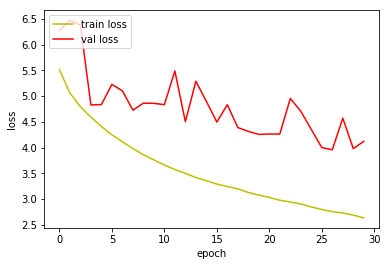

In [8]:
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()   